## Language classification with Naive Bayes

This project was done under the Coursera guided project - [Link](https://www.coursera.org/projects/language-classification)

### 1. Data exploration

In [46]:
###############################################################
# Import Libraries & read data
###############################################################

import numpy as np
import pandas as pd
import string as st
import re, collections
import pickle as pkl

# import visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import models and metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

In [2]:
###############################################################
# Explore the data
###############################################################

# function to read file
def read_file(filename):
    with open(filename,'r') as f:
        data = f.readlines()
    return data

raw_data = dict()
raw_data['sk'] = read_file('data/Sentences/train_sentences.sk')
raw_data['cs'] = read_file('data/Sentences/train_sentences.cs')
raw_data['en'] = read_file('data/Sentences/train_sentences.en')

# function to show the file summaries
def show_summaries(data):
    for lang, sentences in data.items():
        words = ' '.join(sentences).split()
        
        sentence_len = len(sentences)
        words_count = len(words)
        uniq_word_count = len(set(words))
        sample_sentence = ' '.join(sentences[0].split()[0:15])
        
        print('**************************************************')
        print('Language :', lang)
        print('Number of sentences :', sentence_len)
        print('Number of words :', words_count)
        print('Number of unique words :', uniq_word_count)
        print('Sample extract :', sample_sentence)

# print summaries
show_summaries(raw_data)

**************************************************
Language : sk
Number of sentences : 100
Number of words : 2016
Number of unique words : 1322
Sample extract : Pán de Grandes Pascual jasne vysvetlil, aká je pridaná hodnota definície terorizmu, vyjadrením, že definícia,
**************************************************
Language : cs
Number of sentences : 10
Number of words : 158
Number of unique words : 141
Sample extract : Upozorňujeme, že jejím cílem je šetřit penězi za administrativní výdaje.
**************************************************
Language : en
Number of sentences : 100
Number of words : 2381
Number of unique words : 1037
Sample extract : I can understand your approach a little bit.


Zipf's law was originally formulated in terms of quantitative linguistics, stating that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. 

More on the Zipf's Law [here](https://en.wikipedia.org/wiki/Zipf%27s_law)

We will plot the frequency and the rank of the words in each language to test this.

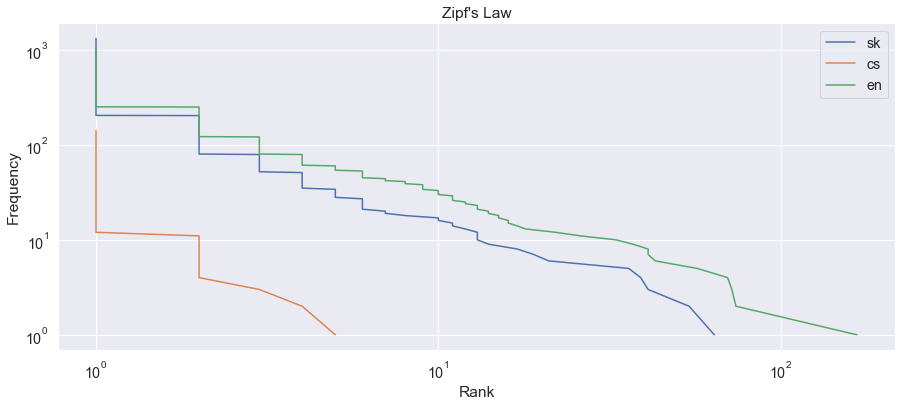

In [4]:
# function to plot the frequency of words in the language 

sns.set(style='darkgrid', font_scale=1.3)
fig, ax = plt.subplots(figsize=(15,6))

def do_law_of_zipf(data):
    '''
    Convert a dictionary (keys are language, and values are lists of sentences)
    into separate Pandas DataFrames for each language, and plots log scales of
    Ranks vs Frequencies, to visualize Zipf's Law.
    
    '''
    languages = list(data.keys())
    
    words_df_dict = dict()
    
    for language in languages:
        words_df_dict[language] = pd.DataFrame()

        words = []
        for sentence in data[language]:
            words.extend(sentence.split())

        words_df_dict[language]['word'] = words
        
    for language in languages:
        freqs = words_df_dict[language]['word'].value_counts().values
        ranks = range(1, len(freqs)+1)
        plt.plot(freqs, ranks, label=language)

    plt.ylabel('Frequency')
    plt.xlabel('Rank')
    plt.yscale('log')
    plt.xscale('log')

    plt.title('Zipf\'s Law')
    plt.legend()

do_law_of_zipf(raw_data)

### 2. Data pre processing

In [11]:
###############################################################
# Function to do some processing on the text
###############################################################

def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    '''
    
    text_pr = text.lower().replace('-', ' ')
    
    # create a translation table which will be used to replace certain characters
    mytable = str.maketrans('\n', ' ', st.punctuation+st.digits)
    text_pr = text_pr.translate(mytable)
    
    return text_pr

process_data = dict()

for k,v in raw_data.items():
    process_sen = []
    for sentence in v:
        process_sen.append(preprocess(sentence))
    process_data[k] = process_sen
    
# compare un processed vs processed data 
print('\n')
print('Raw Data')
show_summaries(raw_data)

print('\n')
print('Processed Data')
show_summaries(process_data)



Raw Data
**************************************************
Language : sk
Number of sentences : 100
Number of words : 2016
Number of unique words : 1322
Sample extract : Pán de Grandes Pascual jasne vysvetlil, aká je pridaná hodnota definície terorizmu, vyjadrením, že definícia,
**************************************************
Language : cs
Number of sentences : 10
Number of words : 158
Number of unique words : 141
Sample extract : Upozorňujeme, že jejím cílem je šetřit penězi za administrativní výdaje.
**************************************************
Language : en
Number of sentences : 100
Number of words : 2381
Number of unique words : 1037
Sample extract : I can understand your approach a little bit.


Processed Data
**************************************************
Language : sk
Number of sentences : 100
Number of words : 1996
Number of unique words : 1207
Sample extract : pán de grandes pascual jasne vysvetlil aká je pridaná hodnota definície terorizmu vyjadrením že definíc

### 4. Naive Bayes Model

**Bayes' Theorem**

\begin{equation}
P(A | B)=\frac{P(B | A) \times P(A)}{P(B)}
\end{equation}

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence `my name is Ari` into one of `sk`, `cs`, or `en`, the following are the probabilities we want to determine.

\begin{equation}
P(\text {sk} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {sk}) \times P(\text {sk})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {cs} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {cs}) \times P(\text {cs})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {en} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {en}) \times P(\text {en})}{P(\text {my name is Ari})}
\end{equation}

**Unseen Data**

Since we assume conditional independence across our features, our numerator term for any of the above equations can be broken into the following.

\begin{equation}
P(\text {my name is Ari} | \text {en}) = P(\text {my} | \text {en}) \times P(\text {name} | \text {en}) \times P(\text {is} | \text {en}) \times P(\text {Ari} | \text {en})
\end{equation}

**Vectorizing Training Data**

|Sentence   	||   my   	| is 	| I 	| love 	| name 	| it 	| Ari 	|
|-----------------	||:------:	|:--:	|:-:	|:----:	|:----:	|:--------:	|:---:	|
| my name is Ari  	||    1   	|  1 	| 0 	|   0  	|   1  	|     0    	|  1  	|
| I love it 	||    0   	|  0 	| 1 	|   1  	|   0  	|     1    	|  0  	|

In [19]:
###############################################################
# Train the model on training data
###############################################################

# create training data
y_train = []
sentences_train = []

for k,v in process_data.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)
        
#vectorize the sentences to create x train
vect = CountVectorizer()
x_train = vect.fit_transform(sentences_train)

# fit the model
nb_classifier = MultinomialNB()
nb_classifier.fit(x_train, y_train)

MultinomialNB()

F1 score for model with no correction -  0.61


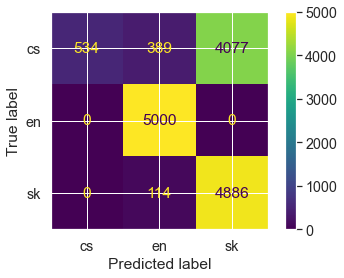

In [39]:
###############################################################
# Predict using the model on validation data
###############################################################

# read validation data
val_data = dict()
val_data['sk'] = read_file('data/Sentences/val_sentences.sk')
val_data['cs'] = read_file('data/Sentences/val_sentences.cs')
val_data['en'] = read_file('data/Sentences/val_sentences.en')

process_val_data = dict()

for k,v in val_data.items():
    process_sen = []
    for sentence in v:
        process_sen.append(preprocess(sentence))
    process_val_data[k] = process_sen
    
# create validation data
y_val = []
sentences_val = []

for k,v in process_val_data.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)
        
#vectorize the sentences to create x train
x_val = vect.transform(sentences_val)

# predicting
pred = nb_classifier.predict(x_val)
print('F1 score for model with no correction - ', np.round(f1_score(y_val, pred, average='weighted'),2))

# plot the confusion matrix
plot_confusion_matrix(nb_classifier, x_val, y_val)

as we can see from the plot above there are lot of misclassification in SK and CS language. We will need to fix this in our model training. 

Currently there are too less CS language input sentences to train. We can try to fix this by providing some parameters in our NB classifier.

F1 score for model with correction -  0.87


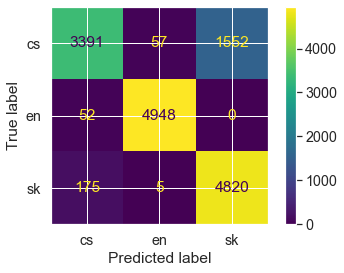

In [40]:
###############################################################
# Train the revised model on training data
###############################################################

nb_classifier_revise = MultinomialNB(alpha=0.1, fit_prior=False)
nb_classifier_revise.fit(x_train, y_train)

pred_revise = nb_classifier_revise.predict(x_val)
print('F1 score for model with correction - ', np.round(f1_score(y_val, pred_revise, average='weighted'),2))

# plot the confusion matrix for revised model
plot_confusion_matrix(nb_classifier_revise, x_val, y_val)

### 5. Using Subwords to Shift Perspective

**Dummy Dataset**

playing ; eating ; play ; reads ; tea

**Step 1**

Break each word into characters

playing > p l a y i n g


**Step 2**

Find common character sequences

ea, ing, play

**Step 3**

Convert dataset using these subwords into

play ing ; ea t ing ; play ; r ea d s ; t ea

**The code logic below is taken from -** https://arxiv.org/abs/1508.07909

In [44]:
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

def get_vocab(data):
    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = collections.defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [45]:
vocab = get_vocab(sentences_train)

In [48]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)
    
merges = collections.defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v
            
merge_ordered = sorted(merges, key=merges.get, reverse=True)

merge_ordered

['the',
 'in',
 'to',
 'st',
 'en',
 'al',
 'an',
 'is',
 're',
 'po',
 'ed',
 'er',
 'ro',
 'it',
 'ne',
 'ie',
 'ch',
 'ia',
 'ov',
 'le',
 'na',
 'ce',
 've',
 'me',
 'and',
 'of',
 'as',
 'de',
 'at',
 'ar',
 'li',
 'pro',
 'on',
 'pr',
 'ing',
 'or',
 'pre',
 'la',
 'je',
 'ion',
 'for',
 'ou',
 'ci',
 'do',
 'se',
 'že',
 'om',
 'sk',
 'ra',
 'sa',
 'ho',
 'te',
 'vo',
 'no',
 'ic',
 'ak',
 'mo',
 'be',
 'lo',
 'pe',
 'ct',
 'ment',
 'by',
 'né',
 'so',
 'that',
 'vy',
 'si',
 'mi',
 'ly',
 'ation',
 'we',
 'mu',
 'bu',
 'ke',
 'il',
 'im',
 'sti',
 'ur',
 'ul',
 'ate',
 'av',
 'con',
 'ad',
 'bo',
 'not',
 'ent',
 'ss',
 'port',
 'ri',
 'vý',
 'ať',
 'ob',
 'su',
 'ran',
 'pod',
 'ity',
 'th',
 'ná',
 'op',
 'am',
 'sl',
 'are',
 'ali',
 'nej',
 'od',
 'com',
 'par',
 'our',
 'práv',
 'ac',
 'áv',
 'sú',
 'et',
 'ut',
 'ých',
 'uje',
 'wh',
 'ren',
 'za',
 'zá',
 'kon',
 'di',
 'ka',
 'vá',
 'us',
 'ag',
 'ni',
 'pri',
 'ny',
 'ál',
 'som',
 'ha',
 'this',
 'hod',
 'dent',
 'ky'

In [49]:
pkl.dump(merge_ordered, open('data/Auxiliary/merge_ordered.pkl', 'wb'))

def split_into_subwords(text):
    merges = pkl.load(open('data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

split_into_subwords('Hello my name is None of your Business!')

'lo my na me is ne of ou in ss us'

In [50]:
# using above subword creation technique let's create new training data
process_data_subwords = dict()

for k,v in process_data.items():
    process_sen = []
    for sentence in v:
        process_sen.append(split_into_subwords(sentence))
    process_data_subwords[k] = process_sen
    
show_summaries(process_data_subwords)

**************************************************
Language : sk
Number of sentences : 100
Number of words : 3944
Number of unique words : 118
Sample extract : de an de al as ne as ve li vy ak je an pr ho
**************************************************
Language : cs
Number of sentences : 10
Number of words : 288
Number of unique words : 85
Sample extract : po me or je že je ím le je it et en za in st
**************************************************
Language : en
Number of sentences : 100
Number of words : 4242
Number of unique words : 104
Sample extract : an st an er un ou ro ch it le it


F1 score for model with subwords -  0.85


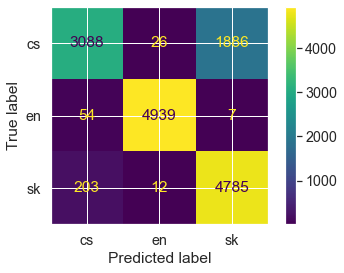

In [54]:
###############################################################
# Train the model on NEW training data
###############################################################

# create training data
data_train_sw = []

for sentence in sentences_train:
    data_train_sw.append(split_into_subwords(sentence))
    
# create validation data
data_val_sw = []

for sentence in sentences_val:
    data_val_sw.append(split_into_subwords(sentence))
    
vect = CountVectorizer()
x_train_sw = vect.fit_transform(data_train_sw)
x_val_sw = vect.transform(data_val_sw)

# fit the model on new training data
nb_classifier_sw = MultinomialNB(alpha=1, fit_prior=False)
nb_classifier_sw.fit(x_train_sw, y_train)

pred_sw = nb_classifier_sw.predict(x_val_sw)
print('F1 score for model with subwords - ', np.round(f1_score(y_val, pred_sw, average='weighted'),2))

# plot the confusion matrix for revised model
sns.set(style='darkgrid', font_scale=1.3)
plot_confusion_matrix(nb_classifier_sw, x_val_sw, y_val)